In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import imageio.v3 as iio
import os
import shutil
from glob import glob
from sklearn.model_selection import GridSearchCV
from PIL import Image
from tqdm import tqdm

In [12]:
(x_minst_train, y_minst_train), (x_minst_test, y_minst_test) = mnist.load_data()
assert x_minst_train.shape == (60000, 28, 28)
assert x_minst_test.shape == (10000, 28, 28)
assert y_minst_train.shape == (60000,)
assert y_minst_test.shape == (10000,)

x_minst_train, x_minst_test = x_minst_train / 255.0, x_minst_test / 255.0
x_minst_train = x_minst_train.reshape(x_minst_train.shape[0], 28, 28, 1)
x_minst_test = x_minst_test.reshape(x_minst_test.shape[0], 28, 28, 1)

x_minst_train, x_minst_val, y_minst_train, y_minst_val = train_test_split(x_minst_train, y_minst_train, test_size=0.25)

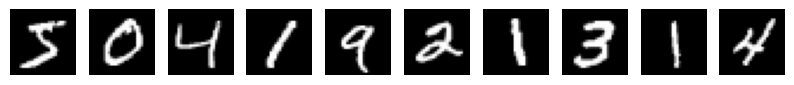

In [3]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(x_minst_train[i], cmap="gray")
    ax.axis("off")

In [13]:
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()
assert x_fashion_train.shape == (60000, 28, 28)
assert x_fashion_test.shape == (10000, 28, 28)
assert y_fashion_train.shape == (60000,)
assert y_fashion_test.shape == (10000,)

x_fashion_train, x_fashion_test = x_fashion_train / 255.0, x_fashion_test / 255.0
x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], 28, 28, 1)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], 28, 28, 1)

x_fashion_train, x_fashion_val, y_fashion_train, y_fashion_val = train_test_split(x_fashion_train, y_fashion_train, test_size=0.25)

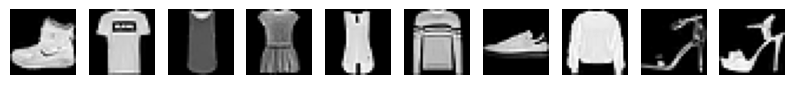

In [6]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(x_fashion_train[i], cmap="gray")
    ax.axis("off")

In [14]:
def create_encoder(input_shape, latent_dim):
    encoder = Sequential([
        Conv2D(64, 3, activation="relu", padding="same", input_shape=input_shape),
        Conv2D(64, 3, activation="relu", padding="same"),
        MaxPooling2D(2),
        BatchNormalization(),
        
        Conv2D(64, 3, activation="relu", padding="same"),
        Conv2D(64, 3, activation="relu", padding="same"),
        MaxPooling2D(2),
        BatchNormalization(),
        
        Conv2D(32, 3, activation="relu", padding="same"),
        Conv2D(32, 3, activation="relu", padding="same"),
        MaxPooling2D(2),
        BatchNormalization(),
        
        Flatten(),
        Dense(latent_dim, activation="relu")
    ])
    return encoder

In [15]:
def create_decoder(output_shape, latent_dim):
    decoder = Sequential([
        Dense(3*3*32, activation="relu", input_shape=(latent_dim,)),
        Reshape((3, 3, 32)),
        
        UpSampling2D(2),
        Conv2D(32, 3, activation="relu", padding="same"),
        Conv2D(32, 3, activation="relu", padding="same"),
        
        UpSampling2D(2),
        Conv2D(64, 3, activation="relu", padding="same"),
        Conv2D(64, 3, activation="relu", padding="same"),
        
        UpSampling2D(2),
        Conv2D(64, 3, activation="relu", padding="same"),
        Conv2D(64, 3, activation="relu", padding="same"),
        
        Conv2D(1, 3, activation="sigmoid", padding="same")
    ])
    return decoder

In [16]:
enc_minst = create_encoder(x_minst_train.shape[1:], latent_dim=6)
dec_minst = create_decoder(x_minst_train.shape[1:], latent_dim=6)

In [17]:
enc_minst.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)       

In [18]:
dec_minst.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 288)               2016      
                                                                 
 reshape (Reshape)           (None, 3, 3, 32)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 6, 6, 32)         0         
 )                                                               
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 conv2d_15 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 12, 12, 32)       0         
 2D)                                                  

In [19]:
enc_fashion = create_encoder(x_fashion_train.shape[1:], latent_dim=6)
dec_fashion = create_decoder(x_fashion_train.shape[1:], latent_dim=6)